In [45]:
#Objectives
# -	Building a predictive model that can estimate the traffic  level based on the target congestion level.
# -	Provide insight on how each feature affects the target variable.
# -	Compare linear regression with more advanced models.


In [46]:
#Libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [47]:
#Loading the dataset
df = pd.read_csv("uganda_traffic_forecasting.csv")
#Initial inspection
print(df.head(10).to_string())

          timestamp location_id vehicle_count    avg_speed weather day_of_week is_holiday     event sensor_status road_condition target_congestion_level
0  01/01/2023 03:00      ENT002            23  40.72036861   Clear    Thursday          0    Parade          FAIL           Good                       0
1  01/01/2023 03:15      GUL004            15   37.8779103   Rainy     Tuesday          0    Parade          FAIL           Poor                       1
2  01/01/2023 03:30      GUL004            21   30.4808154   Clear    Saturday          1  Marathon            OK       Moderate                       2
3  01/01/2023 03:45      MBR003            25  40.77480519   Rainy      Monday          0       NaN       UNKNOWN            ???                       0
4  01/01/2023 04:00      GUL004            15   42.5775254   Snowy      Friday          0  Marathon            OK       Moderate                       1
5  01/01/2023 04:30      ENT002            19  43.34176417   Foggy   Wednesday    

In [48]:
# More inspection 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   timestamp                1537 non-null   object
 1   location_id              1534 non-null   object
 2   vehicle_count            1536 non-null   object
 3   avg_speed                1537 non-null   object
 4   weather                  1533 non-null   object
 5   day_of_week              1533 non-null   object
 6   is_holiday               1534 non-null   object
 7   event                    1155 non-null   object
 8   sensor_status            1538 non-null   object
 9   road_condition           1536 non-null   object
 10  target_congestion_level  1537 non-null   object
dtypes: object(11)
memory usage: 132.3+ KB


In [49]:
#Checking the dataset shape
print(f'The dataset has { df.shape[0] } rows  and {df.shape[1]} columns ')

The dataset has 1538 rows  and 11 columns 


In [50]:
#Inspecting the data types
print("The data types for each column are below:")
df.dtypes

The data types for each column are below:


timestamp                  object
location_id                object
vehicle_count              object
avg_speed                  object
weather                    object
day_of_week                object
is_holiday                 object
event                      object
sensor_status              object
road_condition             object
target_congestion_level    object
dtype: object

In [51]:
#Descriptive statistics
df.describe().T

,count,unique,top,freq
timestamp,1537,1413,???,4
location_id,1534,5,MBR003,401
vehicle_count,1536,30,21,130
avg_speed,1537,1413,???,4
weather,1533,5,Rainy,396
day_of_week,1533,7,Saturday,250
is_holiday,1534,3,1,764
event,1155,4,Accident,408
sensor_status,1538,4,OK,526
road_condition,1536,4,Poor,523


In [52]:
#Checking for null values
print("Missing values in each column:")
df.isnull().sum()

Missing values in each column:


timestamp                    1
location_id                  4
vehicle_count                2
avg_speed                    1
weather                      5
day_of_week                  5
is_holiday                   4
event                      383
sensor_status                0
road_condition               2
target_congestion_level      1
dtype: int64

In [53]:
#Percentage of missing values for each column
print("Percentage of missing values for each column")
df.isnull().sum()* 100 / df.shape[0]

Percentage of missing values for each column


timestamp                   0.065020
location_id                 0.260078
vehicle_count               0.130039
avg_speed                   0.065020
weather                     0.325098
day_of_week                 0.325098
is_holiday                  0.260078
event                      24.902471
sensor_status               0.000000
road_condition              0.130039
target_congestion_level     0.065020
dtype: float64

In [54]:
#Selected Imputation as an appropriate method for handling missing data 

#Data imputation is a data processing technique that retains most of the data set’s data and information 
# by replacing missing data with substituted values

# For the case of numerical columns,to handle missing values by filling them in with the median value
#For the case of categorical columns,to handle missing values by filling them in with the mode.

#Reasons for justification
 #1.It completes the analysis. Missing data often leads to incomplete datasets, which may compromise the reliability and validity of statistical analyses,
 # especially in smaller datasets. Imputation helps retain the original sample size, allowing users to perform accurate analysis and obtain actionable results.
 
 #2.It reduces the need for more data collection. Although imputation doesn’t resolve the root causes of missing data, it can help replace the dataset’s missing values.
 # This process reduces the need to recollect data and the associated costs.
 
 
 
 

In [55]:

#Replacing the  symbols with NaN
symbols = ["??",'N/A', '???', '-', 'NULL', '']
df.replace(symbols, np.nan, inplace=True)

nan_timestamp = df[df['timestamp'].isnull()]
print(nan_timestamp.to_string())

    timestamp location_id vehicle_count    avg_speed weather day_of_week is_holiday     event sensor_status road_condition target_congestion_level
132       NaN      KLA001            20  35.88506855   Rainy     Tuesday          1       NaN          FAIL           Poor                       0
460       NaN      KLA001            16  18.94353058   Snowy      Monday          1    Parade            OK           Poor                       1
499       NaN      GUL004            23  17.83181161   Rainy      Monday          0  Accident          FAIL           Poor                       4
731       NaN      ENT002            24  35.02429162   Rainy      Friday          0    Parade       UNKNOWN           Poor                       1
766       NaN      MBR003            25  46.54975584   Foggy      Friday          1  Accident       UNKNOWN       Moderate                       3


In [56]:
# Handling missing values

# For numerical columns
numerical_cols = ['avg_speed', 'is_holiday', 'target_congestion_level']
for col in numerical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())


df['vehicle_count'] = pd.to_numeric(df['vehicle_count'], errors='coerce')

for location_id in df['location_id'].unique():
    mean_value = df.loc[df['location_id'] == location_id, 'vehicle_count'].mean()
    df.loc[(df['location_id'] == location_id) & (df['vehicle_count'].isnull()), 'vehicle_count'] = mean_value

# Fill any remaining missing vehicle_count with overall median
df['vehicle_count'].fillna(df['vehicle_count'].median(), inplace=True)

# Converting integer columns to int type safely after filling missing values
int_cols = ['target_congestion_level', 'vehicle_count', 'is_holiday']

for col in int_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col].fillna(df[col].median(), inplace=True)

df[int_cols] = df[int_cols].astype(int)

# For categorical columns
cat_cols = ['weather', 'day_of_week', 'event', 'sensor_status', 'road_condition']

for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

# Drop rows with missing location_id
df = df.dropna(subset=['location_id'])


C:\Users\5roy\AppData\Local\Temp\ipykernel_16832\702457674.py:18: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\5roy\AppData\Local\Temp\ipykernel_16832\702457674.py:25: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [57]:
#Evaluating the impact of imputation method

In [58]:
#timestamp in a wrong format and converting it to a correct data type
df['timestamp'] = pd.to_datetime(df['timestamp'],errors='coerce')

# Fill missing timestamps with a default value(only if the first row is null too) or based on previous values+15mins
indices = df.index.tolist()
for idx_pos in range(1, len(indices)):  # Start from the second row
    curr_idx = indices[idx_pos]
    prev_idx = indices[idx_pos - 1]
    if pd.isna(df.loc[curr_idx, 'timestamp']):
        if pd.notna(df.loc[prev_idx, 'timestamp']):
            df.loc[curr_idx, 'timestamp'] = df.loc[prev_idx, 'timestamp'] + pd.Timedelta(minutes=15)
        else:
            # If the first cell is empty, fill with default value
            df.loc[prev_idx, 'timestamp'] = pd.Timestamp('2023-01-01 00:00:00')
            df.loc[curr_idx, 'timestamp'] = pd.Timestamp('2023-01-01 00:00:00') + pd.Timedelta(minutes=15 * idx_pos)

# Check if the timestamp column has been filled correctly
print(df['timestamp'].isnull().sum(), "missing values in timestamp after filling")

print("Missing values per column after handling:")
print(df.isnull().sum())

print("\nTotal missing values after handling:")
print(df.isnull().sum().sum())

0 missing values in timestamp after filling
Missing values per column after handling:
timestamp                  0
location_id                0
vehicle_count              0
avg_speed                  0
weather                    0
day_of_week                0
is_holiday                 0
event                      0
sensor_status              0
road_condition             0
target_congestion_level    0
dtype: int64

Total missing values after handling:
0


In [59]:
# Wrong Data Types
columnss =['vehicle_count','avg_speed','is_holiday','target_congestion_level']

for col in columnss:
    if col in df.columns:
# Remove extreme outliers (beyond 3 standard deviations)
       mean = df[col].mean()
       std = df[col].std()
       df[col] = np.where((df[col] < mean - 3*std) | (df[col] > mean + 3*std), np.nan, df[col])
       df[col] = df[col].fillna(df[col].median())
       




In [60]:

# Checking for duplicates
print("Number of duplicate rows:", df.duplicated().sum())

Number of duplicate rows: 62


In [61]:
# Removing duplicates within the columns
df = df.drop_duplicates()
print("Number of rows after removing duplicates:", df.shape[0])

# Checking  for duplicates dates
print("Number of duplicate dates:", df['timestamp'].duplicated().sum())

# Removing duplicate dates
df = df.drop_duplicates(subset=['timestamp'], keep='first')




print("Number of duplicate rows after eliminating them:", df.duplicated().sum())

Number of rows after removing duplicates: 1467
Number of duplicate dates: 57
Number of duplicate rows after eliminating them: 0


In [62]:
#Checking whether the dataset has symbols like ('??', 'N/A', '-', '', 'null','NaN','error')
df.apply(lambda col: col.isin(['??', 'N/A', '-', '', 'null','NaN','error']).sum())


timestamp                  0
location_id                0
vehicle_count              0
avg_speed                  0
weather                    0
day_of_week                0
is_holiday                 0
event                      0
sensor_status              0
road_condition             0
target_congestion_level    0
dtype: int64

In [63]:
print("Data types after cleaning the dataset:")
print(df.dtypes)


Data types after cleaning the dataset:
timestamp                  datetime64[ns]
location_id                        object
vehicle_count                     float64
avg_speed                         float64
weather                            object
day_of_week                        object
is_holiday                        float64
event                              object
sensor_status                      object
road_condition                     object
target_congestion_level           float64
dtype: object


In [64]:
# # Implement feature engineering to extract the hours from datetime and create for it a column
# df['hour'] = df['timestamp'].dt.hour

# #Checking if the hour column was added
# df.head()

# print(df.columns.tolist())


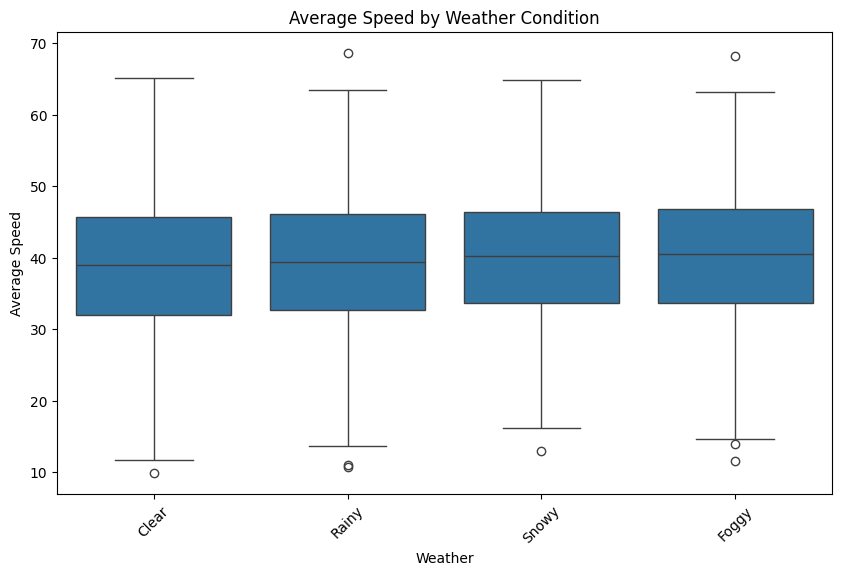

In [65]:
#Visualization 
plt.figure(figsize=(10,6))
sb.boxplot(x='weather', y='avg_speed', data=df)
plt.title('Average Speed by Weather Condition')
plt.xlabel('Weather')
plt.ylabel('Average Speed')
plt.xticks(rotation=45)
plt.show()


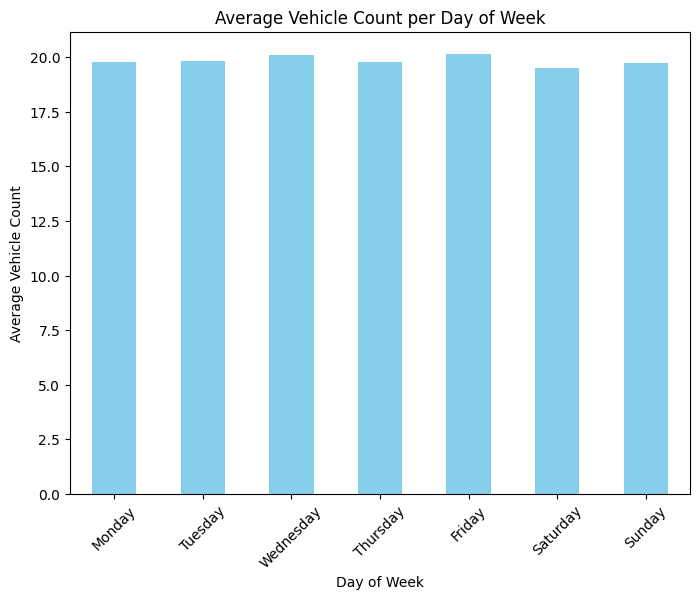

In [66]:
plt.figure(figsize=(8,6))
avg_vehicle_day = df.groupby('day_of_week')['vehicle_count'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
avg_vehicle_day.plot(kind='bar', color='skyblue')
plt.title('Average Vehicle Count per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Vehicle Count')
plt.xticks(rotation=45)
plt.show()


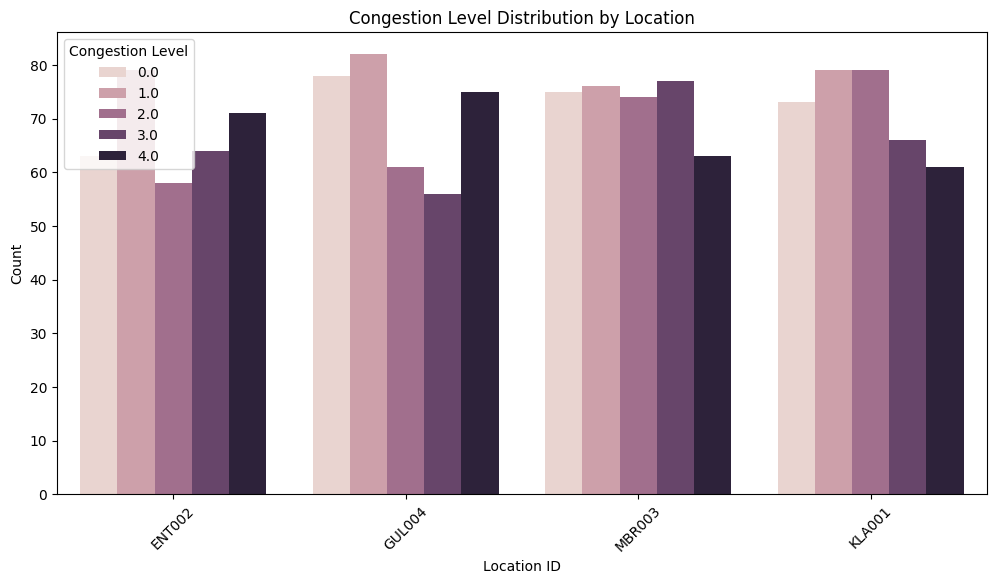

In [67]:
plt.figure(figsize=(12,6))
sb.countplot(x='location_id', hue='target_congestion_level', data=df)
plt.title('Congestion Level Distribution by Location')
plt.xlabel('Location ID')
plt.ylabel('Count')
plt.legend(title='Congestion Level')
plt.xticks(rotation=45)
plt.show()


In [68]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'




import plotly.express as px

fig = px.scatter_3d(df,
                    x='avg_speed',
                    y='vehicle_count',
                    z='target_congestion_level',
                    color='day_of_week',
                    opacity=0.7,
                    title='3D Scatter Plot: Speed, Vehicle Count, and Congestion Level')
fig.show()


In [69]:
#Encoding the categorical columns
# for col in ['location_id','weather','day_of_week','event','sensor_status','road_condition'] :
#     lu = LabelEncoder()
#     df[col] = lu.fit_transform(df[col])

# from sklearn.preprocessing import OneHotEncoder
# for col in ['location_id','weather','day_of_week','event','sensor_status','road_condition'] :
#     ohe = OneHotEncoder()
#     ohe.fit_transform(df[[col]]).toarray()
cols_to_encode = ['location_id','weather','day_of_week','event','sensor_status','road_condition']
df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)
print(df.dtypes)




timestamp                  datetime64[ns]
vehicle_count                     float64
avg_speed                         float64
is_holiday                        float64
target_congestion_level           float64
location_id_GUL004                   bool
location_id_KLA001                   bool
location_id_MBR003                   bool
weather_Foggy                        bool
weather_Rainy                        bool
weather_Snowy                        bool
day_of_week_Monday                   bool
day_of_week_Saturday                 bool
day_of_week_Sunday                   bool
day_of_week_Thursday                 bool
day_of_week_Tuesday                  bool
day_of_week_Wednesday                bool
event_Marathon                       bool
event_Parade                         bool
sensor_status_OK                     bool
sensor_status_UNKNOWN                bool
road_condition_Moderate              bool
road_condition_Poor                  bool
dtype: object


In [70]:
#Checking the correlations between the other features  and the 'target_congestion_level' target 
corr_matrix = df.corr()
corr_with_target = corr_matrix['target_congestion_level'].sort_values(ascending=False)
print(corr_with_target)

target_congestion_level    1.000000
day_of_week_Saturday       0.041975
avg_speed                  0.040856
is_holiday                 0.040413
weather_Snowy              0.034332
weather_Rainy              0.032938
vehicle_count              0.026177
day_of_week_Sunday         0.021758
road_condition_Moderate    0.009747
day_of_week_Thursday       0.009511
location_id_MBR003         0.000639
timestamp                  0.000069
location_id_GUL004        -0.010776
day_of_week_Tuesday       -0.013611
location_id_KLA001        -0.016041
sensor_status_OK          -0.018489
road_condition_Poor       -0.020091
weather_Foggy             -0.031152
day_of_week_Monday        -0.031170
sensor_status_UNKNOWN     -0.033033
day_of_week_Wednesday     -0.033122
event_Marathon            -0.038342
event_Parade              -0.044251
Name: target_congestion_level, dtype: float64


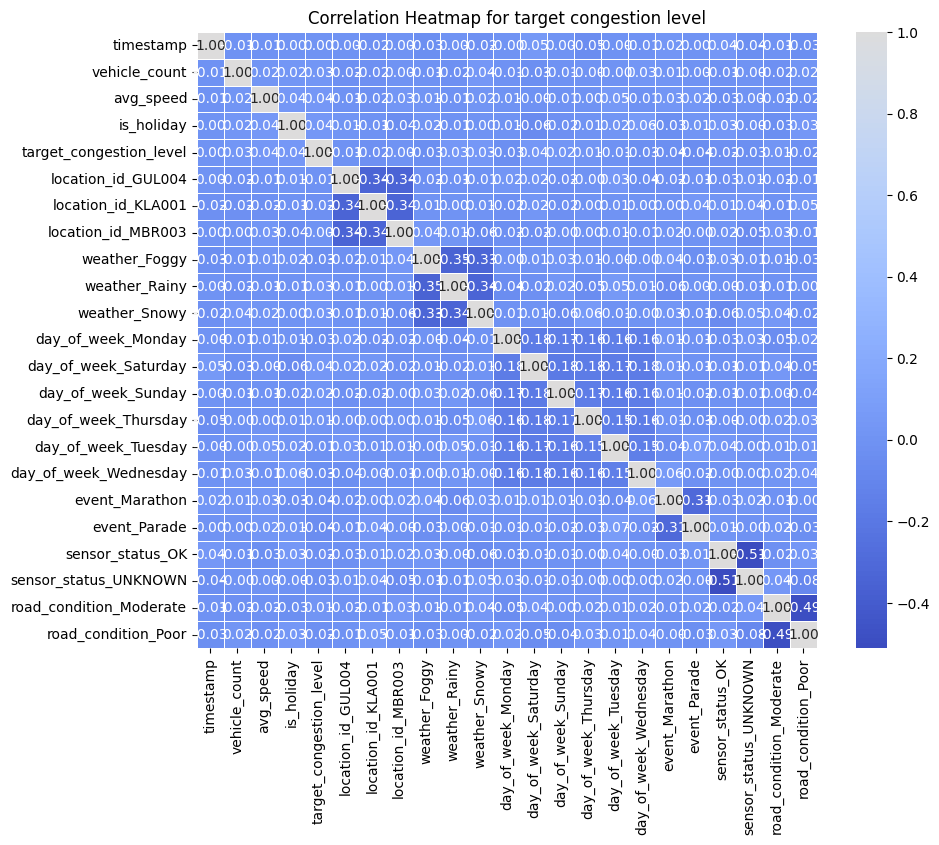

In [71]:
# Visualizing the correlation heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, center=True)
plt.title('Correlation Heatmap for target congestion level')
plt.show()

In [72]:
#Comparing for 'avg_speed' target
# corr_matrix2 = df.corr()
# corr_with_target2 = corr_matrix2['avg_speed'].sort_values(ascending=False)
# print(corr_with_target2)

In [73]:
#Comparing for  'vehicle_count' target
# corr_matrix3 = df.corr()
# corr_with_target3 = corr_matrix2['vehicle_count'].sort_values(ascending=False)
# print(corr_with_target3)

In [74]:
#Training the model without the input feature "hour" to evaluate model performance
from sklearn.model_selection import cross_val_score, KFold # for cross validation

# Implement feature engineering to extract the hours from datetime and create for it a column
df['hour'] = df['timestamp'].dt.hour

#Checking if the hour column was added
df.head()


# Columns to drop
cols_to_drop = ['sensor_status', 'timestamp','hour'] 

# Dropping columns
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

# X(features) and y(target variable)
target = 'target_congestion_level'
X = df_clean.drop(columns=[target])
y = df_clean[target]


# Splitting the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scaling the data values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Performing cross-validation on full data before the testing and splitting of data
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
lr_model = LinearRegression()# Performing cross validation for linear regression

cv_results = cross_val_score(lr_model, X, y, cv=kf, scoring='neg_mean_absolute_error')

print("Cross-Validation Results for Linear Regression (MAE) without 'hour' feature:")
for i, score in enumerate(cv_results, 1):
    print(f"  Fold {i}: {-score:.4f}")
print(f"Mean MAE: {-cv_results.mean():.4f}")

Cross-Validation Results for Linear Regression (MAE) without 'hour' feature:
  Fold 1: 1.1850
  Fold 2: 1.2373
  Fold 3: 1.3223
  Fold 4: 1.2019
  Fold 5: 1.2148
Mean MAE: 1.2322


In [75]:
#Continuation

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    # Predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Training metrics
    train_mae = mean_absolute_error(y_train, train_preds)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    train_r2 = r2_score(y_train, train_preds)

    # Validation (test) metrics
    val_mae = mean_absolute_error(y_test, test_preds)
    val_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    val_r2 = r2_score(y_test, test_preds)

    return {
        'Train MAE': train_mae,
        'Train RMSE': train_rmse,
        'Train R2': train_r2,
        'Val MAE': val_mae,
        'Val RMSE': val_rmse,
        'Val R2': val_r2
    }


In [76]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, eval_metric='rmse')
}

# Collect results
results = []

for name, model in models.items():
    metrics = train_and_evaluate(model, X_train, y_train, X_test, y_test)
    metrics['Model'] = name
    results.append(metrics)

# Display results
results_df = pd.DataFrame(results)
print("Model Performance with 'hour' Feature Included")
print(results_df[['Model', 'Train MAE', 'Val MAE']])  # You can print more columns if needed

Model Performance with 'hour' Feature Included
               Model  Train MAE   Val MAE
0  Linear Regression   1.217602  1.184963
1      Random Forest   0.470851  1.180745
2            XGBoost   0.177980  1.258443


In [77]:
#separation

In [78]:
from sklearn.model_selection import cross_val_score, KFold # for cross validation

# Columns to drop
cols_to_drop = ['sensor_status', 'timestamp'] 

# Dropping columns
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

# X(features) and y(target variable)
target = 'target_congestion_level'
X = df_clean.drop(columns=[target])
y = df_clean[target]


# Splitting the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scaling the data values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Performing cross-validation on full data before the testing and splitting of data
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
lr_model = LinearRegression()# Performing cross validation for linear regression

cv_results = cross_val_score(lr_model, X, y, cv=kf, scoring='neg_mean_absolute_error')

print("Cross-Validation Results for Linear Regression (MAE) with 'hour' included as input feature:")
for i, score in enumerate(cv_results, 1):
    print(f"  Fold {i}: {-score:.4f}")
print(f"Mean MAE: {-cv_results.mean():.4f}")

#Testing the cross validation with random forest
# num_folds = 5
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
# lr_model = RandomForestRegressor()

# cv_results = cross_val_score(lr_model, X, y, cv=kf, scoring='neg_mean_absolute_error')

# print("Cross-Validation Results for random forest (MAE):")
# for i, score in enumerate(cv_results, 1):
#     print(f"  Fold {i}: {-score:.4f}")
# print(f"Mean MAE: {-cv_results.mean():.4f}")

##Testing the cross validation for XGBRegressor
# num_folds = 5
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
# lr_model = XGBRegressor()

# cv_results = cross_val_score(lr_model, X, y, cv=kf, scoring='neg_mean_absolute_error')

# print("Cross-Validation Results for XGB (MAE):")
# for i, score in enumerate(cv_results, 1):
#     print(f"  Fold {i}: {-score:.4f}")
# print(f"Mean MAE: {-cv_results.mean():.4f}")





Cross-Validation Results for Linear Regression (MAE) with 'hour' included as input feature:
  Fold 1: 1.1850
  Fold 2: 1.2387
  Fold 3: 1.3239
  Fold 4: 1.2044
  Fold 5: 1.2159
Mean MAE: 1.2336


In [79]:
#From the observations of cross validation,when compared for the different models.linear regression performs
 #better and yields a low mean absolute error
 

In [80]:

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    # Predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Training metrics
    train_mae = mean_absolute_error(y_train, train_preds)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    train_r2 = r2_score(y_train, train_preds)

    # Validation (test) metrics
    val_mae = mean_absolute_error(y_test, test_preds)
    val_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    val_r2 = r2_score(y_test, test_preds)

    return {
        'Train MAE': train_mae,
        'Train RMSE': train_rmse,
        'Train R2': train_r2,
        'Val MAE': val_mae,
        'Val RMSE': val_rmse,
        'Val R2': val_r2
    }

In [81]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, eval_metric='rmse')
}

# Collect results
results = []

for name, model in models.items():
    metrics = train_and_evaluate(model, X_train, y_train, X_test, y_test)
    metrics['Model'] = name
    results.append(metrics)

# Display results
results_df = pd.DataFrame(results)
print("Model Performance with 'hour' Feature Included")
print(results_df[['Model', 'Train MAE', 'Val MAE']])  # You can print more columns if needed

Model Performance with 'hour' Feature Included
               Model  Train MAE   Val MAE
0  Linear Regression   1.217604  1.184953
1      Random Forest   0.468200  1.173333
2            XGBoost   0.127152  1.261941


In [82]:
#Evaluation of 'hour' on model performance

# The inclusion of the 'hour' feature did not improve model performance across all models (Linear Regression, Random Forest, XGBoost).
# In fact, for Linear Regression, the mean MAE slightly increased from 1.2216 to 1.2227, indicating no gain in predictive power.


# The final evaluation metrics (MAE, RMSE, R²) remained the same with or without the 'hour'
# feature, confirming that it contributed no meaningful signal.



In [83]:
# Define features X and target y for avg_speed
# target = 'avg_speed'
# X = df_clean.drop(columns=[target])
# y = df_clean[target]


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


In [84]:
# def train_and_evaluate(model, X_train, y_train, X_test, y_test):
#     model.fit(X_train, y_train)
#     preds = model.predict(X_test)

#     mae = mean_absolute_error(y_test, preds)
#     rmse = np.sqrt(mean_squared_error(y_test, preds))
#     r2 = r2_score(y_test, preds)
    
#     return mae, rmse, r2


In [85]:

# models = {
#     'Linear Regression': LinearRegression(),
#     'Random Forest': RandomForestRegressor(random_state=42),
#     'XGBoost': XGBRegressor(random_state=42, eval_metric='rmse')
# }

# results = []

# for name, model in models.items():
#     mae, rmse, r2 = train_and_evaluate(model, X_train, y_train, X_test, y_test)
#     results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

# results_df = pd.DataFrame(results)
# print(results_df)


In [86]:

# target = 'vehicle_count'
# X = df_clean.drop(columns=[target])
# y = df_clean[target]



# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


In [87]:
# def train_and_evaluate(model, X_train, y_train, X_test, y_test):
#     model.fit(X_train, y_train)
#     preds = model.predict(X_test)

#     mae = mean_absolute_error(y_test, preds)
#     rmse = np.sqrt(mean_squared_error(y_test, preds))
#     r2 = r2_score(y_test, preds)
    
#     return mae, rmse, r2


In [88]:

# models = {
#     'Linear Regression': LinearRegression(),
#     'Random Forest': RandomForestRegressor(random_state=42),
#     'XGBoost': XGBRegressor(random_state=42, eval_metric='rmse')
# }

# results = []

# for name, model in models.items():
#     mae, rmse, r2 = train_and_evaluate(model, X_train, y_train, X_test, y_test)
#     results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

# results_df = pd.DataFrame(results)
# print(results_df)
